### Question 2 Analysis


In [ ]:
# Import required libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_minimal

# File paths (adjust if needed)
fastest_laps_path = 'https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/fastestlaps_detailed.csv'
pitstops_path = 'https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/pitstops.csv'

# Read datasets
fastest_laps = pd.read_csv(fastest_laps_path)
pitstops = pd.read_csv(pitstops_path)

# Function to convert time strings into seconds
def time_to_seconds(time_str):
    if pd.isnull(time_str) or not isinstance(time_str, str):
        return None
    try:
        parts = time_str.split(':')
        if len(parts) == 2:  # MM:SS.sss
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 3:  # HH:MM:SS
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = float(parts[2])
            return hours * 3600 + minutes * 60 + seconds
        else:
            return None
    except ValueError:
        return None

# Apply time conversion
fastest_laps['Time'] = fastest_laps['Time'].apply(time_to_seconds)
if 'Total' in pitstops:
    pitstops['Total'] = pitstops['Total'].apply(time_to_seconds)

# Encode Driver and Car as numerical features
fastest_laps['DriverEncoded'] = pd.factorize(fastest_laps['Driver'])[0]
fastest_laps['CarEncoded'] = pd.factorize(fastest_laps['Car'])[0]

# Extract and combine features
lap_times = fastest_laps[['Time']].dropna()  # Lap times
pitstop_durations = pitstops[['Total']].dropna() if 'Total' in pitstops else None  # Pitstop durations
positions = fastest_laps[['DriverEncoded', 'CarEncoded']].dropna()  # Encoded features

# Combine lap times, pitstop durations, and encoded features
if pitstop_durations is not None:
    combined_features = pd.concat([lap_times, pitstop_durations], axis=1).dropna()
else:
    combined_features = lap_times

# Add encoded features
combined_features = pd.concat([combined_features, positions], axis=1).dropna()

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(combined_features)

# Apply PCA
pca = PCA()
data_pca = pca.fit_transform(data_standardized)
explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Retain top components that explain ~95% variance
n_components = sum(explained_variance_ratio < 0.95) + 1
pca = PCA(n_components=n_components)
data_pca_reduced = pca.fit_transform(data_standardized)

# Prepare target variable (lap times for simplicity)
y = lap_times['Time'][:len(combined_features)]  # Ensure matching indices
X = combined_features  # Features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(data_pca_reduced, y, test_size=0.2, random_state=42)

# Train model on original data
model_original = LinearRegression()
model_original.fit(X_train, y_train)
y_pred_original = model_original.predict(X_test)

# Metrics for original data
mse_original = mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

# Train model on PCA-transformed data
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train_pca)
y_pred_pca = model_pca.predict(X_test_pca)

# Metrics for PCA-transformed data
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

# Output results
results = {
    "Original Data": {
        "MSE": mse_original,
        "R²": r2_original
    },
    "PCA-Transformed Data": {
        "MSE": mse_pca,
        "R²": r2_pca
    }
}

print("Performance Metrics:", results)


Performance Metrics: {'Original Data': {'MSE': 1461.5610596615918, 'R²': 0.04888524814662898}, 'PCA-Transformed Data': {'MSE': 1461.5610596615918, 'R²': 0.04888524814662898}}


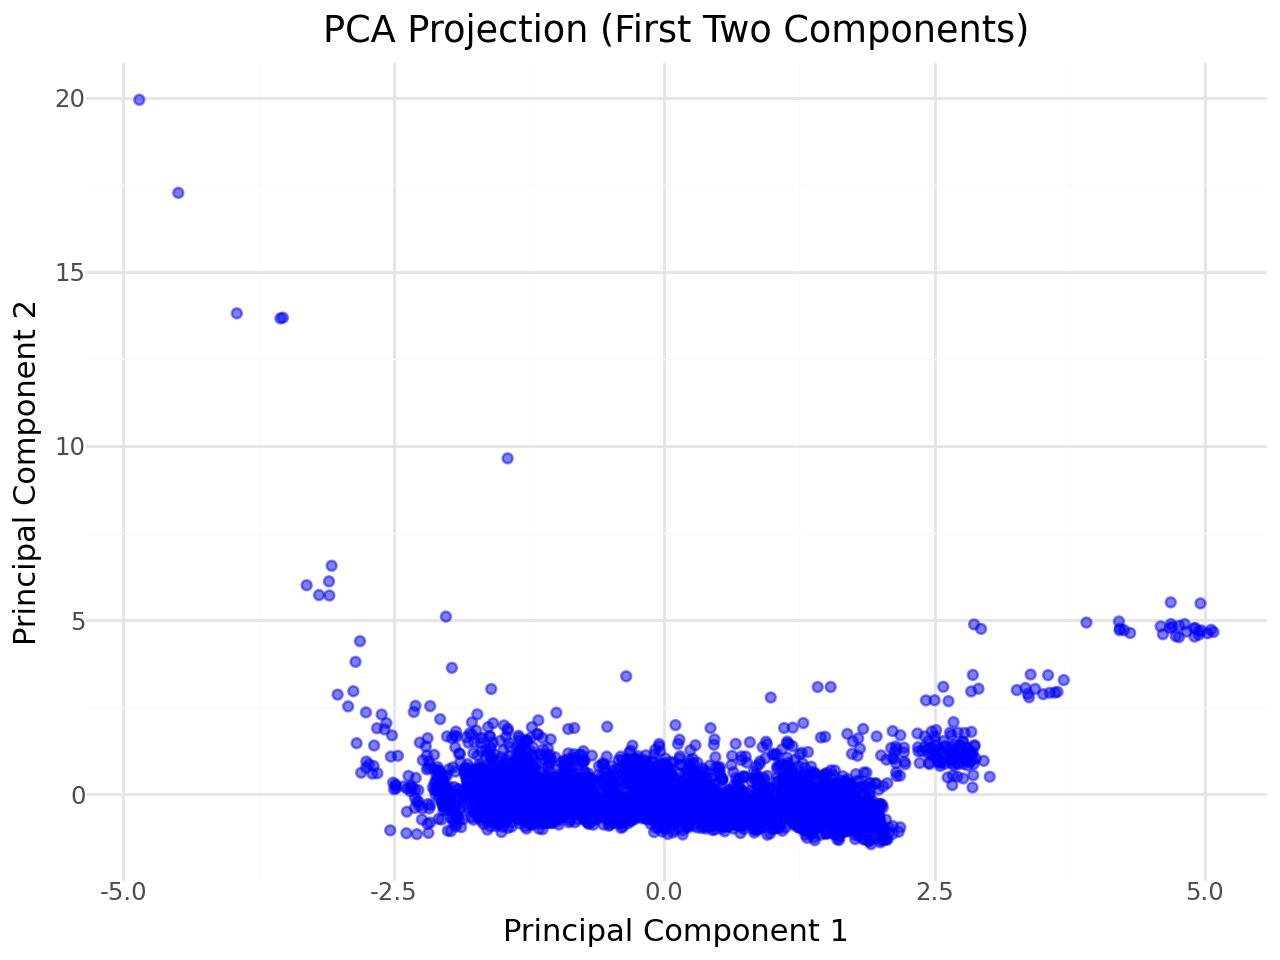

In [ ]:
# PCA Projection Scatter Plot
if data_pca_reduced.shape[1] == 1:  # Handle single component case
    pca_projection_data = pd.DataFrame({
        'PC1': data_pca_reduced[:, 0],
        'Index': range(len(data_pca_reduced))  # Dummy y-axis
    })
    projection_plot = (
        ggplot(pca_projection_data, aes(x='PC1', y='Index')) +
        geom_point(color="blue", alpha=0.5) +
        labs(title="PCA Projection (Single Component)", x="Principal Component 1", y="Index") +
        theme_minimal()
    )
else:
    pca_projection_data = pd.DataFrame({
        'PC1': data_pca_reduced[:, 0],
        'PC2': data_pca_reduced[:, 1]
    })
    projection_plot = (
        ggplot(pca_projection_data, aes(x='PC1', y='PC2')) +
        geom_point(color="blue", alpha=0.5) +
        labs(title="PCA Projection (First Two Components)", x="Principal Component 1", y="Principal Component 2") +
        theme_minimal()
    )
projection_plot


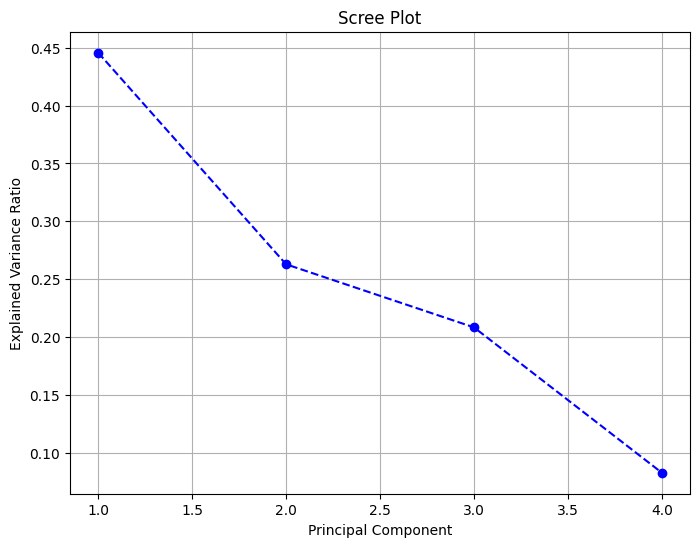

In [ ]:
import matplotlib.pyplot as plt

# Matplotlib Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


### Question 3 Analysis


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# File paths (adjust if needed)
fastest_laps_path = 'https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/fastestlaps_detailed.csv'
race_details_path = 'https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/pitstops.csv'

# Read datasets
fastest_laps = pd.read_csv(fastest_laps_path)
race_details = pd.read_csv(race_details_path)

# Dataset 1: Calculate lap time variance from fastest_laps
def time_to_seconds(time_str):
    if pd.isnull(time_str) or not isinstance(time_str, str):
        return None
    try:
        parts = time_str.split(':')
        if len(parts) == 2:  # Format MM:SS.sss
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 3:  # Format HH:MM:SS
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = float(parts[2])
            return hours * 3600 + minutes * 60 + seconds
        else:
            return None
    except ValueError:
        return None

fastest_laps['Time'] = fastest_laps['Time'].apply(time_to_seconds)
if 'Grand Prix' not in fastest_laps.columns:
    print("Column 'Grand Prix' missing from fastest_laps, inspect dataset for consistency.")
if 'Grand Prix' not in race_details.columns:
    print("Column 'Grand Prix' missing from race_details, inspect dataset for consistency.")

lap_time_variance = fastest_laps.groupby('Grand Prix')['Time'].var().reset_index()
lap_time_variance.columns = ['Grand Prix', 'Lap_Time_Variance']

# Dataset 2: Extract race characteristics from race_details
if 'Laps' in race_details.columns and 'PTS' in race_details.columns:
    race_characteristics = race_details.groupby('Grand Prix').agg(
        Num_Laps=('Laps', 'max'),  # Maximum laps in a race
        Total_Points=('PTS', 'sum')  # Total points awarded in the race
    ).reset_index()
else:
    print("Columns 'Laps' or 'PTS' missing in race_details. Inspect dataset for necessary adjustments.")
    race_characteristics = pd.DataFrame({'Grand Prix': [], 'Num_Laps': [], 'Total_Points': []})

# Align results without merging: Combine statistics into a new DataFrame
analysis_data = pd.DataFrame({
    'Grand Prix': lap_time_variance['Grand Prix'],
    'Lap_Time_Variance': lap_time_variance['Lap_Time_Variance'],
    'Num_Laps': race_characteristics.set_index('Grand Prix').reindex(lap_time_variance['Grand Prix'])['Num_Laps'].values,
    'Total_Points': race_characteristics.set_index('Grand Prix').reindex(lap_time_variance['Grand Prix'])['Total_Points'].values
})

# Prepare data for clustering
features = analysis_data[['Lap_Time_Variance', 'Num_Laps', 'Total_Points']]
features = features.dropna()  # Drop any rows with missing values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with the optimal number of clusters (e.g., 3 based on Elbow)
kmeans = KMeans(n_clusters=3, random_state=42)
analysis_data['Cluster'] = kmeans.fit_predict(features_scaled)

# Visualize clusters
sns.scatterplot(
    data=analysis_data,
    x='Lap_Time_Variance',
    y='Num_Laps',
    hue='Cluster',
    palette='viridis'
)
plt.title('Clusters of Circuits by Lap Time Variance and Characteristics')
plt.xlabel('Lap Time Variance')
plt.ylabel('Number of Laps')
plt.legend(title='Cluster')
plt.show()

# Analyze clusters
cluster_analysis = analysis_data.groupby('Cluster').mean()
print("Cluster Analysis:")
print(cluster_analysis)


Columns 'Laps' or 'PTS' missing in race_details. Inspect dataset for necessary adjustments.


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by StandardScaler.

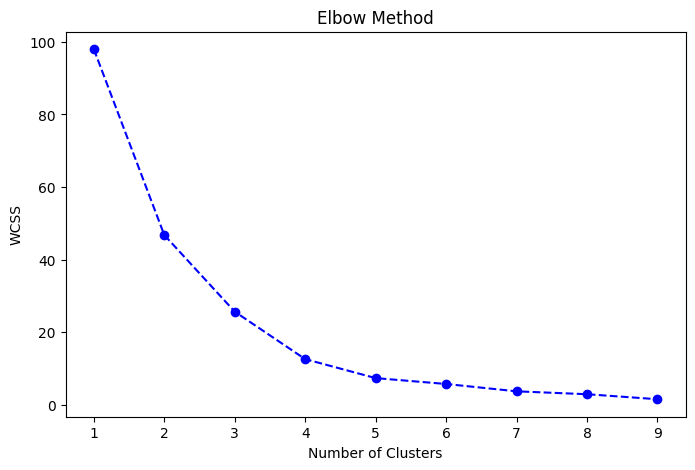

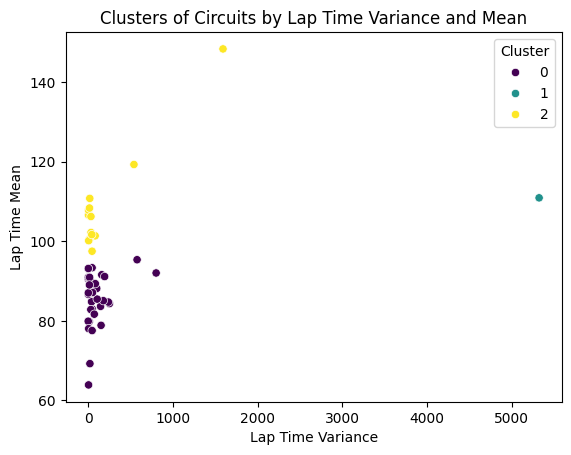


--- Cluster 0 ---
          Grand Prix  Time_Variance  Time_Mean  Cluster
0   70th Anniversary       0.750094  90.542450        0
2          Argentina      46.143167  93.349416        0
3          Australia      57.554795  89.374781        0
4            Austria     152.199652  78.856735        0
8             Brazil     146.266328  83.630252        0
9             Canada      46.909649  83.007429        0
13             Eifel       2.423361  90.947350        0
14    Emilia Romagna      11.763730  79.811397        0
15            Europe     160.141965  91.583882        0
16            France     250.939210  84.331006        0
18     Great Britain     100.879067  88.131080        0
19           Hungary      39.858768  84.808394        0
20             India      24.761163  90.171662        0
21  Indianapolis 500       4.406268  63.873000        0
22             Italy      84.316318  89.334823        0
24         Las Vegas       0.133645  79.897500        0
25        Luxembourg     238.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
fastest_laps_path = 'https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/fastestlaps_detailed.csv'
fastest_laps = pd.read_csv(fastest_laps_path)

# Convert 'Time' column to numeric
def time_to_seconds(time_str):
    if pd.isnull(time_str) or not isinstance(time_str, str):
        return None
    try:
        parts = time_str.split(':')
        if len(parts) == 2:  # Format MM:SS.sss
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 3:  # Format HH:MM:SS
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = float(parts[2])
            return hours * 3600 + minutes * 60 + seconds
        else:
            return None
    except ValueError:
        return None

# Apply conversion to the 'Time' column
fastest_laps['Time'] = fastest_laps['Time'].apply(time_to_seconds)

# Drop rows with invalid 'Time' or 'Grand Prix'
fastest_laps = fastest_laps.dropna(subset=['Time', 'Grand Prix'])

# Group by 'Grand Prix' and calculate variance and mean
lap_time_variance = fastest_laps.groupby('Grand Prix')['Time'].var().reset_index()
lap_time_mean = fastest_laps.groupby('Grand Prix')['Time'].mean().reset_index()

# Combine variance and mean into a single DataFrame
analysis_data = pd.merge(
    lap_time_variance,
    lap_time_mean,
    on='Grand Prix',
    suffixes=('_Variance', '_Mean')
)

# Prepare data for clustering
features = analysis_data[['Time_Variance', 'Time_Mean']].dropna()  # Drop any rows with NaN
analysis_data = analysis_data.loc[features.index]  # Align analysis_data with features

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
analysis_data = analysis_data.reset_index(drop=True)  # Reset index to match the clustering output
analysis_data['Cluster'] = kmeans.fit_predict(features_scaled)

# Visualize clusters
sns.scatterplot(
    data=analysis_data,
    x='Time_Variance',
    y='Time_Mean',
    hue='Cluster',
    palette='viridis'
)
plt.title('Clusters of Circuits by Lap Time Variance and Mean')
plt.xlabel('Lap Time Variance')
plt.ylabel('Lap Time Mean')
plt.legend(title='Cluster')
plt.show()

# Individual Cluster Exploration
for cluster in sorted(analysis_data['Cluster'].unique()):
    print(f"\n--- Cluster {cluster} ---")
    cluster_data = analysis_data[analysis_data['Cluster'] == cluster]
    print(cluster_data)
    print(f"Summary Statistics for Cluster {cluster}:")
    print(cluster_data[['Time_Variance', 'Time_Mean']].describe())


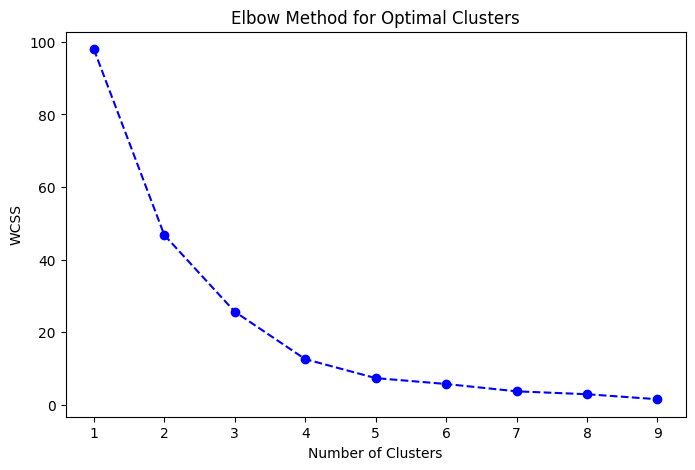

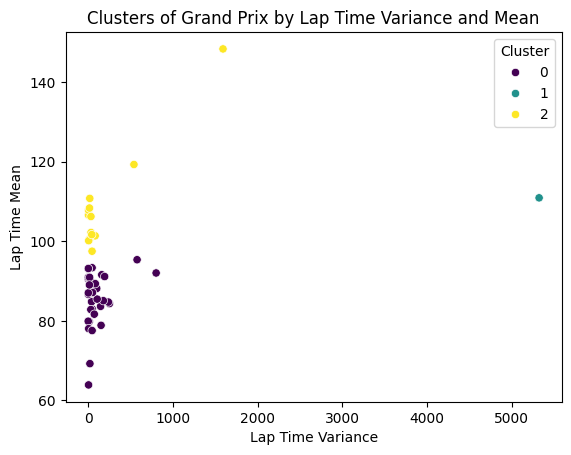


--- Cluster 0 ---
          Grand Prix  Lap_Time_Variance  Lap_Time_Mean  Cluster
0   70th Anniversary           0.750094      90.542450        0
2          Argentina          46.143167      93.349416        0
3          Australia          57.554795      89.374781        0
4            Austria         152.199652      78.856735        0
8             Brazil         146.266328      83.630252        0
9             Canada          46.909649      83.007429        0
13             Eifel           2.423361      90.947350        0
14    Emilia Romagna          11.763730      79.811397        0
15            Europe         160.141965      91.583882        0
16            France         250.939210      84.331006        0
18     Great Britain         100.879067      88.131080        0
19           Hungary          39.858768      84.808394        0
20             India          24.761163      90.171662        0
21  Indianapolis 500           4.406268      63.873000        0
22             Italy 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
fastest_laps_path = 'https://raw.githubusercontent.com/pranavski/Formula-1-analysis/refs/heads/master/fastestlaps_detailed.csv'
fastest_laps = pd.read_csv(fastest_laps_path)

# Convert 'Time' column to numeric
def time_to_seconds(time_str):
    if pd.isnull(time_str) or not isinstance(time_str, str):
        return None
    try:
        parts = time_str.split(':')
        if len(parts) == 2:  # Format MM:SS.sss
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 3:  # Format HH:MM:SS
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = float(parts[2])
            return hours * 3600 + minutes * 60 + seconds
        else:
            return None
    except ValueError:
        return None

# Apply conversion to the 'Time' column
fastest_laps['Time'] = fastest_laps['Time'].apply(time_to_seconds)

# Drop rows with invalid 'Time' or 'Grand Prix'
fastest_laps = fastest_laps.dropna(subset=['Time', 'Grand Prix'])

# Calculate variance of lap times for each Grand Prix
grand_prix_variance = fastest_laps.groupby('Grand Prix')['Time'].var().reset_index()
grand_prix_variance.columns = ['Grand Prix', 'Lap_Time_Variance']

# Calculate mean of lap times for each Grand Prix
grand_prix_mean = fastest_laps.groupby('Grand Prix')['Time'].mean().reset_index()
grand_prix_mean.columns = ['Grand Prix', 'Lap_Time_Mean']

# Merge variance and mean
grand_prix_stats = pd.merge(grand_prix_variance, grand_prix_mean, on='Grand Prix')

# Handle missing values
grand_prix_stats = grand_prix_stats.dropna()  # Drop rows with NaN values

# Standardize the data
scaler = StandardScaler()
stats_scaled = scaler.fit_transform(grand_prix_stats[['Lap_Time_Variance', 'Lap_Time_Mean']])

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(stats_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
grand_prix_stats['Cluster'] = kmeans.fit_predict(stats_scaled)

# Visualize clusters
sns.scatterplot(
    data=grand_prix_stats,
    x='Lap_Time_Variance',
    y='Lap_Time_Mean',
    hue='Cluster',
    palette='viridis'
)
plt.title('Clusters of Grand Prix by Lap Time Variance and Mean')
plt.xlabel('Lap Time Variance')
plt.ylabel('Lap Time Mean')
plt.legend(title='Cluster')
plt.show()

# Individual Cluster Exploration
for cluster in sorted(grand_prix_stats['Cluster'].unique()):
    print(f"\n--- Cluster {cluster} ---")
    cluster_data = grand_prix_stats[grand_prix_stats['Cluster'] == cluster]
    print(cluster_data)
    print(f"Summary Statistics for Cluster {cluster}:")
    print(cluster_data[['Lap_Time_Variance', 'Lap_Time_Mean']].describe())
